# Tema 1 TIA Lazar Vlad-Andrei 332AB


# Documentatie Proiect: Detectarea Anomaliilor:

## Descrierea problemei:
Detectarea anomaliilor identifica punctele de date care se abat de la modelele generale. In cazul nostru datele de incarcare a masinilor electrice.

Exemple : consum exterm, rata de incarcare foarte scazuta etc.

## Descrierea setului de date:

Setul de date: ev_charging_patterns.csv

Coloane analizate:
- Energy Consumed (kWh)
- Charging Duration (hours)
- Charging Rate (kW)
- State of Charge (End %)
- Temperature (°C)

Preprocesare:
- Valori lipsa: inlocuite cu media
- Normalizare: datele numerice au fost standardizat
 (StandardScaler)

Vizualizari: Grafice scatter pentru perechi relevante:
- Energy Consumed (kWh) vs. Charging Duration (hours)
- Charging Rate (kW)    vs. State of Charge (End %)
- Temperature (°C)      vs. Energy Consumed (kWh)
- Charging Rate (kW)    vs. Temperature (°C)

## Metodele de detectare a anomaliilor utilizate:

###Metode implementate:

#### KNN (K-Nearest Neighbors):
- Parametri: n_neighbors=6, method='median'
- alegerea unui numar moderat de vecini (6) echilibreaza sensibilitatea si robustetea
- un numar mic de vecini (ex. 3) poate fi sensibil la zgomot, iar unul mare (ex. 10) poate dilua informatiile locale
- median este mai robustă decat largest, deoarece reduce impactul valorilor extreme asupra calculului distantei
- Scor Silueta: 0.25

#### ABOD (Angle-Based Outlier Detection):
- Parametri: contamination=0.04
- reducerea de la valori mai mari (ex. 0.1) la 0.04 reflecta faptul ca datasetul pare să contină relativ putine anomalii, iar cresterea acestei valori ar putea eticheta eronat punctele normale ca fiind anomalii
- Scor Silueta: 0.29

#### Isolation Forest:
- Parametri: n_estimators=300, contamination=0.05
- un numar mai mare de estimatori (arbori) asigură o mai buna reprezentare a structurii datelor, imbunatatind stabilitatea detectiei
- proportia moderata de anomalii (5%) se aliniază cu natura datasetului, unde anomaliile par rare, dar nu absente.
- Scor Silueta: 0.30

#### One-Class SVM:
- Parametri: kernel='rbf', nu=0.03
- Kernel-ul radial este potrivit pentru a modela separatii non-liniare, ceea ce este necesar pentru datele noastre care nu au o separare liniara evidentă intre punctele normale si anormale
- Scor Silueta: 0.22

## Evaluarea performantelor si interpretarea rezultatelor:

### Scorurile Silueta:
- KNN: 0.25
- Se observa ca modelul detectează bine anomaliile locale
- ABOD: 0.29
- Sensibil la anomaliile unghiulare, dar cu zgomot in rezultatele finale
- Isolation Forest: 0.30
- Cele mai clare separari intre punctele normale si anormale.
- One-Class SVM: 0.22
- Performanta scazuta, cu etichetari inconsistene.

### Concluzii:
Isolation Forest este metoda recomandata pentru acest dataset, datorita scorului Silueta cel mai mare.

### Bibliografie:
- PyOD Documentation: https://pyod.readthedocs.io/
- Scikit-learn Documentation: https://scikit-learn.org/
- Kaggle Datasets: https://www.kaggle.com/datasets

## Setup initial:

In [1]:
# Instalare PyOD:
!pip install pyod

# Importam bibliotecile necesare:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.metrics import silhouette_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=0d0dd3da75572acd1fdfd4ccb6beb44406c1ff06c46ba72d3f720314a91dc277
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


## Incarcarea datelor:

In [3]:
def load_data(file_path):
    """
    Incarca datele si afiseaza informatii despre acestea.
    """
    data = pd.read_csv(file_path)
    print("Informatii despre setul de date:")
    print(data.info())
    print("\nPrimele 5 randuri:")
    display(data.head())
    return data

## Preprocesarea datelor:

In [4]:
def preprocess_data(data, numerical_columns):
    """
    Preproceseaza datele:
    - Inlocuieste valorile lipsa cu media coloanei.
    - Normalizeaza coloanele numerice.
    """
    # Inlocuire valori lipsa
    for col in numerical_columns:
        if col in data.columns and data[col].isnull().any():
            mean_value = data[col].mean()
            print(f"Inlocuim valorile lipsa din coloana '{col}' cu media: {mean_value}")
            data[col].fillna(mean_value, inplace=True)

    # Normalizare date
    scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    print("Datele numerice au fost normalizate!")
    return data


## Vizualizarea datelor dupa preprocesare:

In [5]:
def plot_relevant_pairs(data, relevant_pairs, title_prefix=""):
    """
    Genereaza grafice scatter pentru perechile de coloane specificate.
    """
    for col1, col2 in relevant_pairs:
        if col1 not in data.columns or col2 not in data.columns:
            print(f"Sarim perechea invalida: ({col1}, {col2})")
            continue

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=data[col1], y=data[col2])
        plt.title(f"{title_prefix} {col1} vs. {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

## Detectarea anomaliilor:

In [6]:
def detect_anomalies(data, numerical_columns, models):
    """
    Aplica modele de detectare a anomaliilor pe datele numerice.
    """
    X = data[numerical_columns].values  # Extrage datele numerice

    for name, model in models.items():
        print(f"Antrenam modelul: {name}")
        model.fit(X)  # Antreneaza modelul
        data[f"{name}_Anomalies"] = model.predict(X)  # Detecteaza anomaliile
        print(f"Anomalii detectate utilizand {name}.")
    return data


## Vizualizarea anomaliilor:

In [7]:
def visualize_anomalies_with_scatter(data, models, relevant_pairs):
    """
    Creeaza grafice scatter pentru anomaliile detectate de fiecare model.
    """
    for name in models.keys():
        print(f"Generam grafice scatter pentru anomaliile detectate de modelul {name}...")
        for col1, col2 in relevant_pairs:
            if col1 not in data.columns or col2 not in data.columns:
                print(f"Sarim perechea invalida: ({col1}, {col2})")
                continue

            plt.figure(figsize=(6, 4))
            sns.scatterplot(
                x=data[col1],
                y=data[col2],
                hue=data[f"{name}_Anomalies"],
                palette={0: "blue", 1: "red"}
            )
            plt.title(f"Anomalii detectate de {name}: {col1} vs. {col2}")
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.show()


## Evaluarea performantei:

In [8]:
def evaluate_models(data, numerical_columns, models):
    """
    Evalueaza performanta fiecarui model utilizand scorul Silhouette.
    """
    X = data[numerical_columns].values  # Extrage datele numerice
    for name in models.keys():
        labels = data[f"{name}_Anomalies"]  # Etichete pentru anomalii
        score = silhouette_score(X, labels)
        print(f"Scorul Silueta pentru {name}: {score:.2f}")


## main


In [24]:
def main(file_path, numerical_columns, relevant_pairs):
    """
    Functia principala care coordoneaza toate etapele proiectului.
    """
    # Incarcare date
    data = load_data(file_path)

   # Preprocesare date
    data = preprocess_data(data, numerical_columns)

    # Generare grafice scatter dupa preprocesare
    print("\nGeneram grafice scatter dupa preprocesare:")
    plot_relevant_pairs(data, relevant_pairs, title_prefix="Dupa Preprocesare")

    # Initializare modele
    models = {
    'KNN': KNN(n_neighbors=6, method='median', metric='minkowski'),
    'ABOD': ABOD(contamination=0.04),
    'Isolation Forest': IForest(n_estimators=300, contamination=0.05, max_samples=256),
    'One-Class SVM': OCSVM(kernel='rbf', nu=0.03)
    }



    # Detectare anomalii
    data = detect_anomalies(data, numerical_columns, models)

    # Vizualizare anomalii
    visualize_anomalies_with_scatter(data, models, relevant_pairs)

    # Evaluare performanta
    evaluate_models(data, numerical_columns, models)

    return data


## Configurare si rulare:

Informatii despre setul de date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Cha

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


Inlocuim valorile lipsa din coloana 'Energy Consumed (kWh)' cu media: 42.64289425435557
Inlocuim valorile lipsa din coloana 'Charging Rate (kW)' cu media: 25.96300342597954
Datele numerice au fost normalizate!

Generam grafice scatter dupa preprocesare:


<ipython-input-4-1abf7549f484>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mean_value, inplace=True)


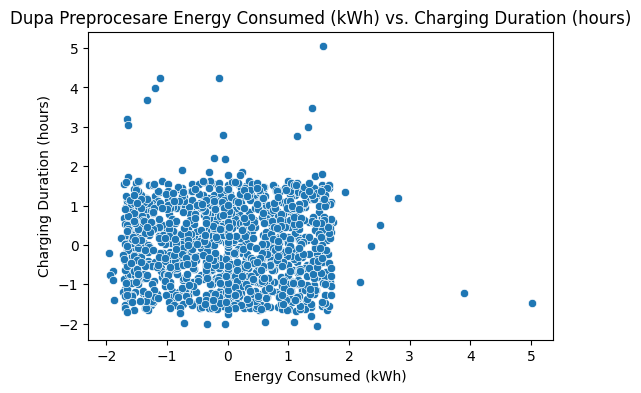

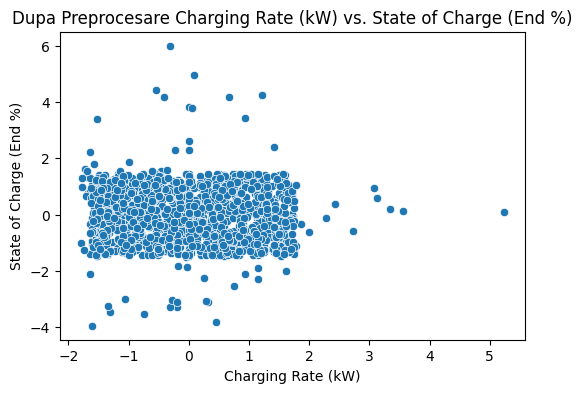

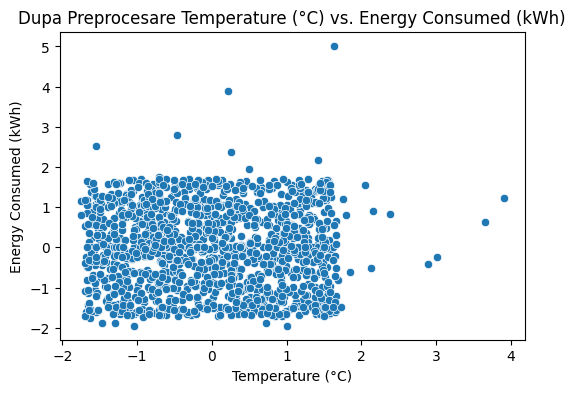

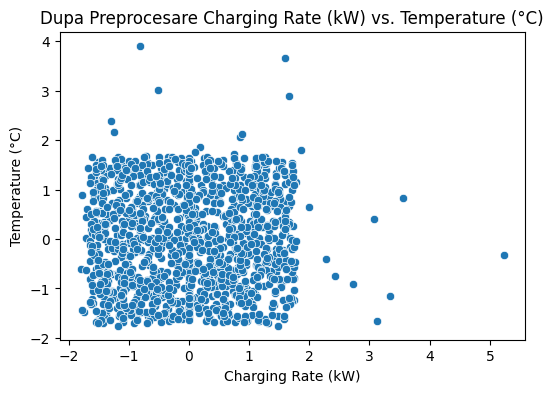

Antrenam modelul: KNN
Anomalii detectate utilizand KNN.
Antrenam modelul: ABOD
Anomalii detectate utilizand ABOD.
Antrenam modelul: Isolation Forest
Anomalii detectate utilizand Isolation Forest.
Antrenam modelul: One-Class SVM
Anomalii detectate utilizand One-Class SVM.
Generam grafice scatter pentru anomaliile detectate de modelul KNN...


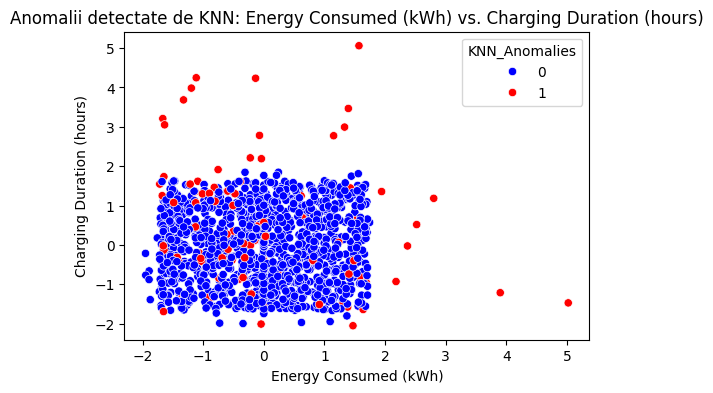

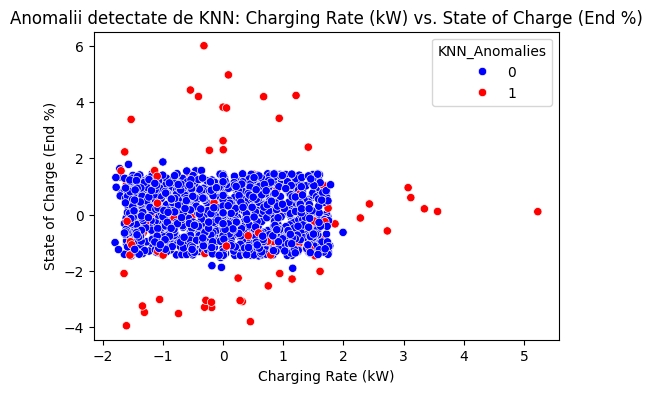

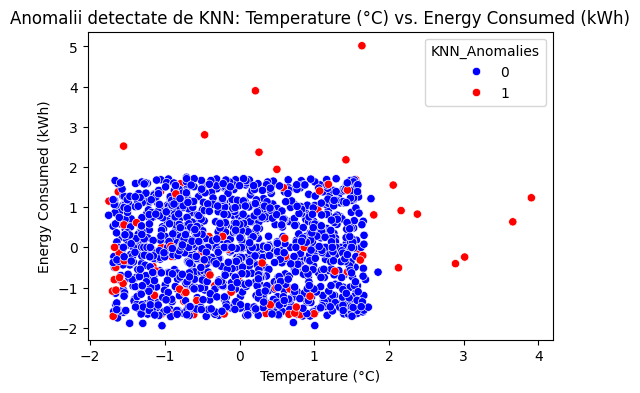

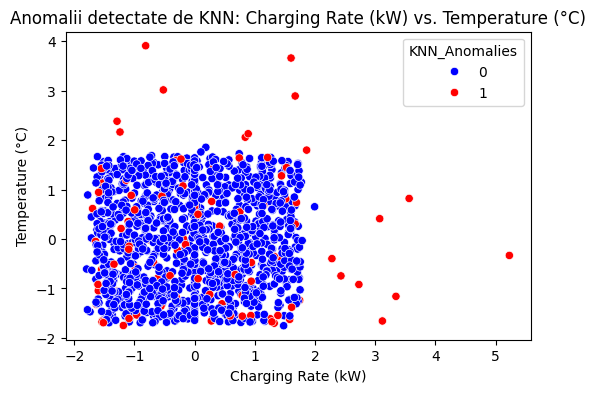

Generam grafice scatter pentru anomaliile detectate de modelul ABOD...


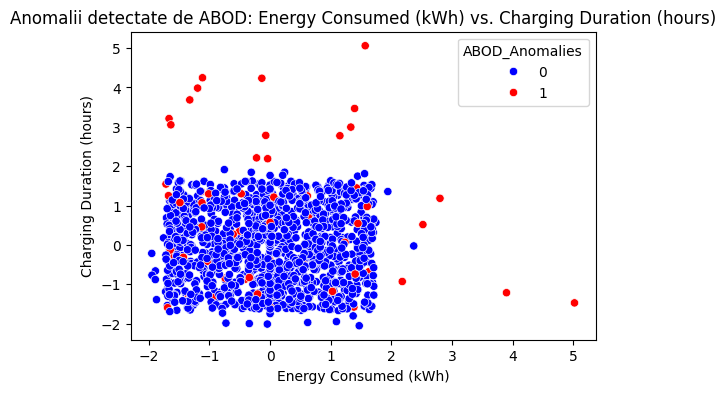

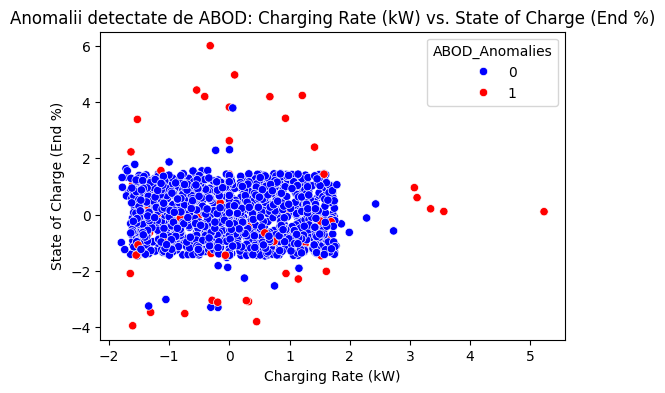

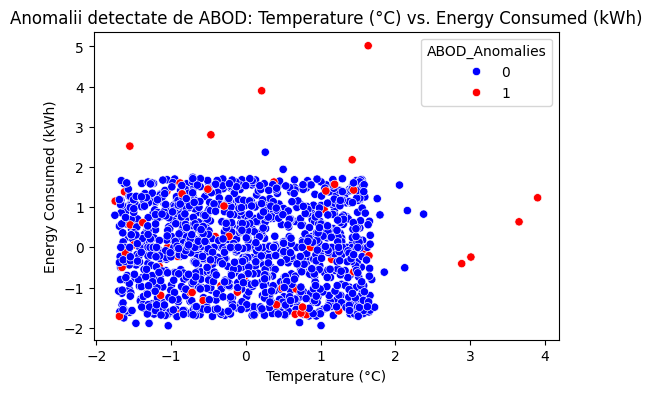

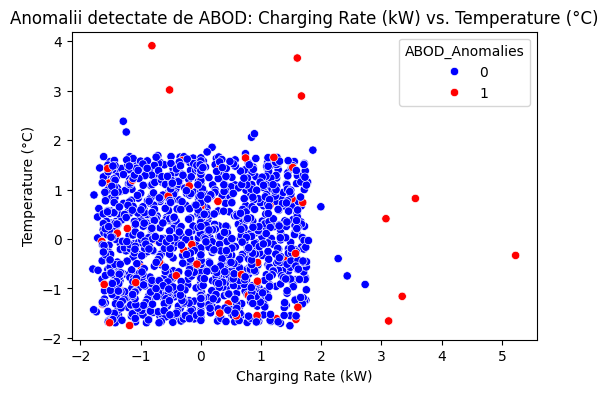

Generam grafice scatter pentru anomaliile detectate de modelul Isolation Forest...


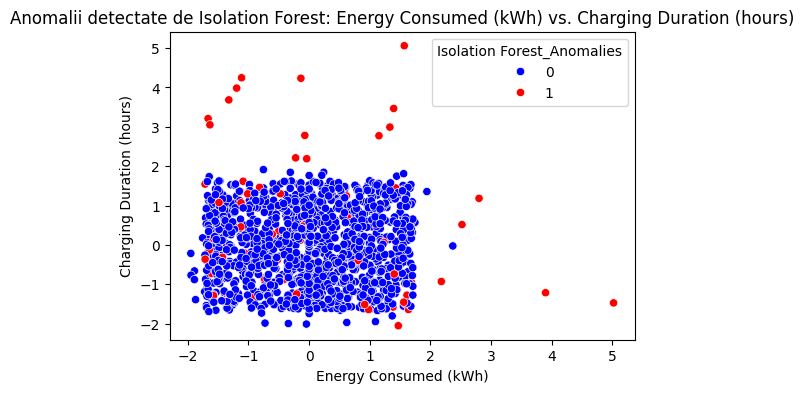

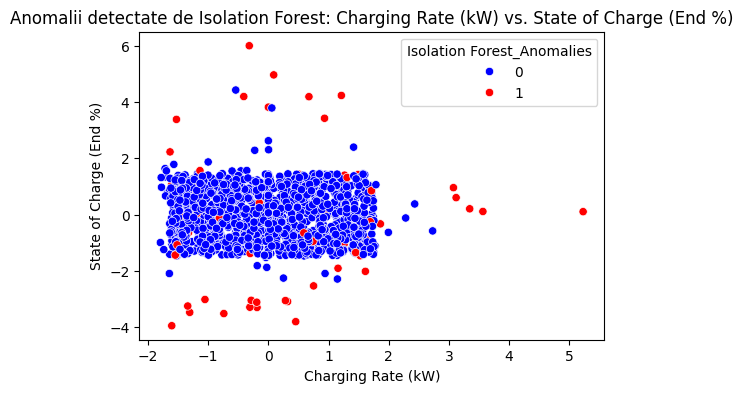

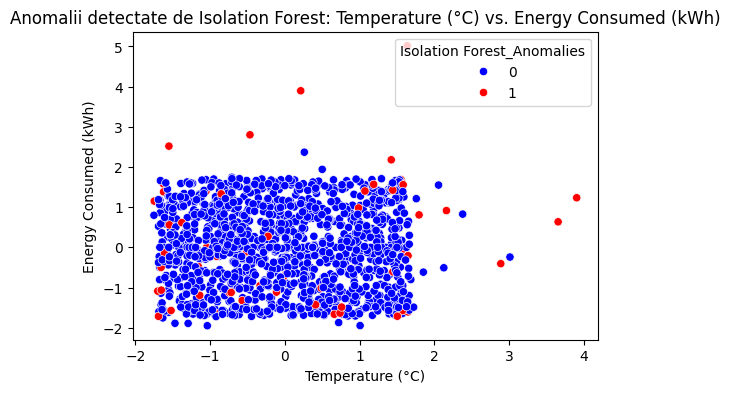

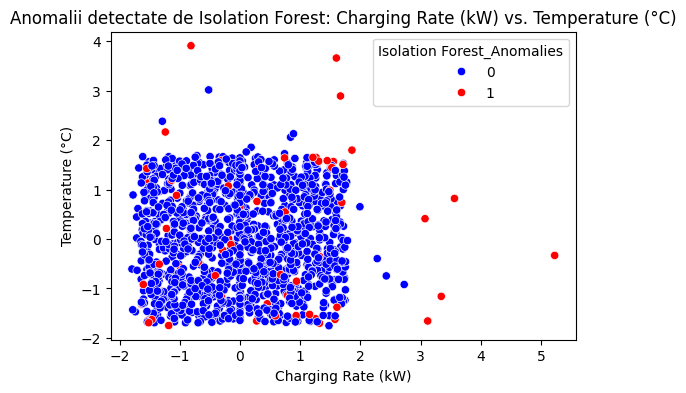

Generam grafice scatter pentru anomaliile detectate de modelul One-Class SVM...


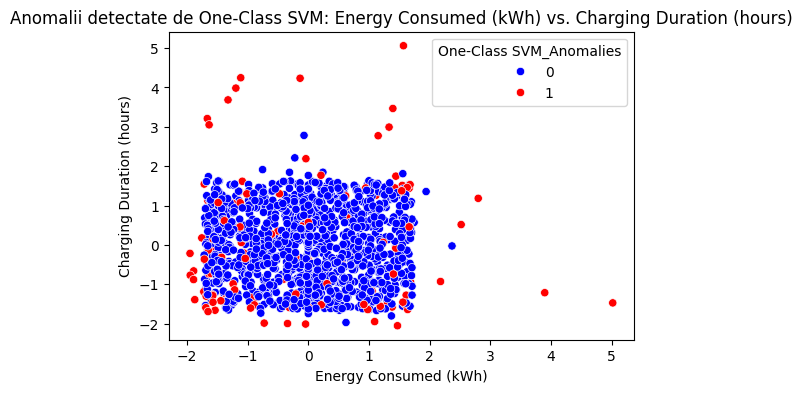

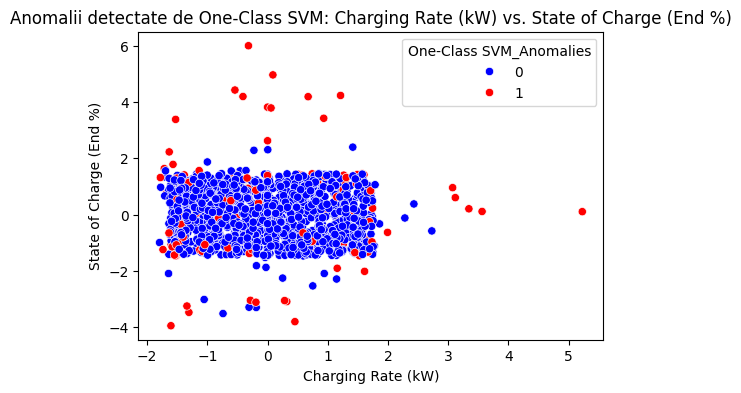

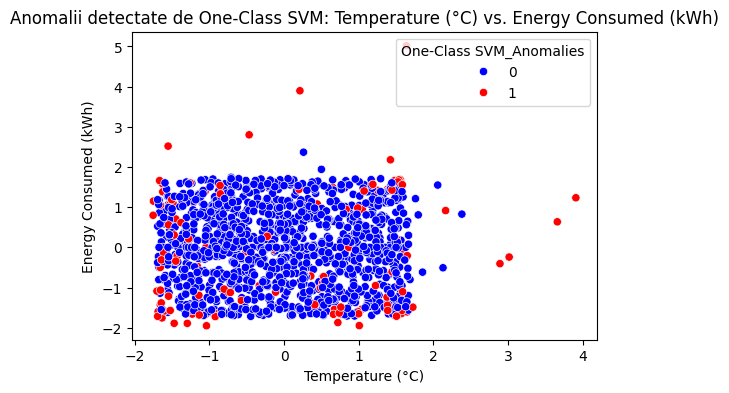

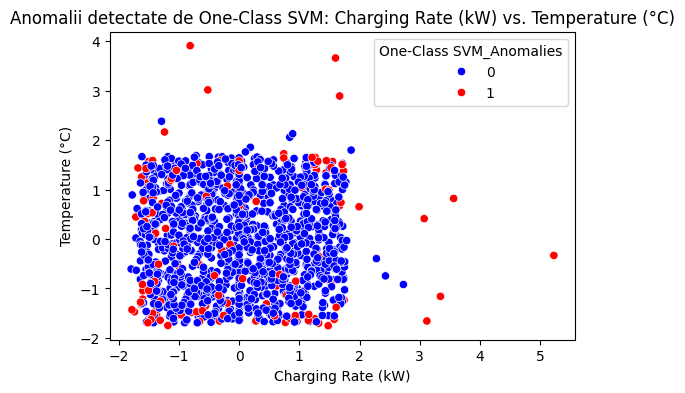

Scorul Silueta pentru KNN: 0.25
Scorul Silueta pentru ABOD: 0.29
Scorul Silueta pentru Isolation Forest: 0.30
Scorul Silueta pentru One-Class SVM: 0.22


In [25]:
file_path = "ev_charging_patterns.csv"
numerical_columns = [
    'Energy Consumed (kWh)', 'Charging Duration (hours)',
    'Charging Rate (kW)', 'State of Charge (End %)', 'Temperature (°C)'
]
relevant_pairs = [
    ('Energy Consumed (kWh)', 'Charging Duration (hours)'),
    ('Charging Rate (kW)', 'State of Charge (End %)'),
    ('Temperature (°C)', 'Energy Consumed (kWh)'),
    ('Charging Rate (kW)', 'Temperature (°C)')
]

# Rulam functia principala
data = main(file_path, numerical_columns, relevant_pairs)